In [1]:
# apt-get install libhdf5-dev
! pip install --user versioned-hdf5
! pip install --user PyQt5

In [2]:
import numpy as np
import pickle
import os
import h5py
import matplotlib.pyplot as plt
from scipy.stats import norm

val_dir = "/home/felixj/WD/finn-radioml/datasets"
print(val_dir)

/home/felixj/WD/finn-radioml/datasets


# Load dataset

In [3]:
h5_file = h5py.File(val_dir + "/2018/GOLD_XYZ_OSC.0001_1024.hdf5",'r')
X = h5_file['X']
Y = np.argmax(h5_file['Y'], axis=1) # comes in one-hot encoding
Z = h5_file['Z'][:,0]

np.random.seed(2018)
test_indices = []
for mod in range(0, 24): #all modulations (0 to 23)
    for snr_idx in range(0, 26): #all SNRs (0 to 25 = -20dB to +30dB)
        start_idx = 26*4096*mod + 4096*snr_idx
        indices_subclass = list(range(start_idx, start_idx+4096))

        split = int(np.ceil(0.1 * 4096)) #90%/10% split
        np.random.shuffle(indices_subclass)
        train_indices_subclass, val_indices_subclass = indices_subclass[split:], indices_subclass[:split]

        if snr_idx >= 25: #only SNR >= +30dB
            test_indices.extend(val_indices_subclass)

test_indices = np.sort(test_indices)

X_test = X[test_indices]
Y_test = Y[test_indices]
Z_test = Z[test_indices]

# note: labels given in the "classes.txt" file are not in the correct order 
# (https://github.com/radioML/dataset/issues/25)
mod_classes = ['OOK','4ASK','8ASK','BPSK','QPSK','8PSK','16PSK','32PSK',
'16APSK','32APSK','64APSK','128APSK','16QAM','32QAM','64QAM','128QAM','256QAM',
'AM-SSB-WC','AM-SSB-SC','AM-DSB-WC','AM-DSB-SC','FM','GMSK','OQPSK']
snr_classes = np.arange(-20., 32., 2) # -20dB to 30dB

print(X.shape)
print(Y.shape)
print(Z.shape)

print(test_indices)
print(X_test.shape)
print(Y_test.shape)
print(Z_test.shape)

(2555904, 1024, 2)
(2555904,)
(2555904,)
[ 102401  102404  102414 ... 2555870 2555878 2555889]
(9840, 1024, 2)
(9840,)
(9840,)


# Quantize dataset

In [4]:
def quantize(data):
    #quantization parameters from training
    quant_min = -2.0
    quant_max = 2.0

    quant_range = quant_max - quant_min
    data_quant = (data - quant_min) / quant_range
    data_quant = np.round(data_quant * 256) - 128
    data_quant = np.clip(data_quant, -128, 127)
    data_quant = data_quant.astype(np.int8)
    return data_quant

#whole validation set:
#X_test_q = quantize(X_test)

# Inspect a sample

Modulation: 16QAM, SNR: 30.0 dB, Index: 1381528


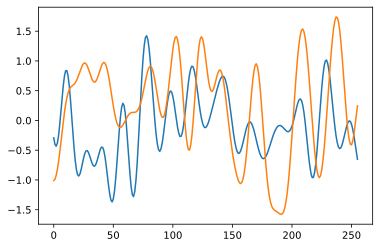

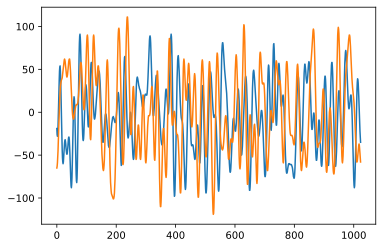

In [16]:
mod = 12 # 0 to 23
snr_idx = 25 # 0 to 25 = -20dB to +30dB
sample = 1176 # 0 to 4096
####
idx = 26*4096*mod + 4096*snr_idx + sample
data, mod, snr = X[idx], Y[idx], Z[idx]
data_q = quantize(X[idx])
plt.figure()
plt.plot(data[:256])
plt.figure()
plt.plot(data_q)
print("Modulation: %s, SNR: %.1f dB, Index: %d" % (mod_classes[mod], snr, idx))

# Histograms

-20 dB I mean: -0.000255, median: -0.000609, std_dev: 0.707664
-20 dB I range: [-3.756177,3.741601]
-20 dB I 99%-range: [-1.823456,1.823863]
-20 dB I 95%-range: [-1.387074,1.386703]
-20 dB Q mean: 0.000419, median: 0.000718, std_dev: 0.707071
-20 dB Q range: [-3.601681,3.521541]
-20 dB Q 99%-range: [-1.822796,1.820081]
-20 dB Q 95%-range: [-1.386398,1.385958]
+30 dB I mean: -0.088932, median: -0.114244, std_dev: 5.839872
+30 dB I range: [-21.509262,16.829208]
+30 dB I 99%-range: [-12.459468,12.393332]
+30 dB I 95%-range: [-10.238321,10.078929]
+30 dB Q mean: -0.046665, median: 0.062055, std_dev: 5.923172
+30 dB Q range: [-17.632803,19.184885]
+30 dB Q 99%-range: [-12.438347,12.968071]
+30 dB Q 95%-range: [-10.377147,10.340333]


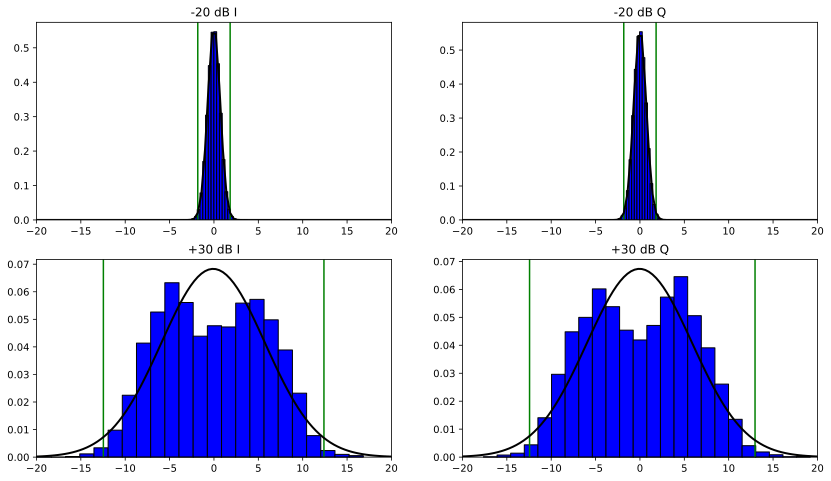

In [13]:
#mods = list(range(0, 17)) # 0 to 23
#mods += list(range(19, 24))
#mods = list(range(0, 24)) # 0 to 23
%config InlineBackend.figure_format = 'svg'
mods = [18]
####
data_I_low = []
data_Q_low = []
data_I_high = []
data_Q_high = []
for mod in mods:
    snr_idx = 0 # 0 to 25 = -20dB to +30dB
    idx = 26*4096*mod + 4096*snr_idx
    data_I_low = np.concatenate((data_I_low, X[idx:idx+4096,:,0]), axis=None)
    data_Q_low = np.concatenate((data_Q_low, X[idx:idx+4096,:,1]), axis=None)

    snr_idx = 25 # 0 to 25 = -20dB to +30dB
    idx = 26*4096*mod + 4096*snr_idx
    data_I_high = np.concatenate((data_I_high, X[idx:idx+4096,:,0]), axis=None)
    data_Q_high = np.concatenate((data_Q_high, X[idx:idx+4096,:,1]), axis=None)

def analyze(data, title, subplot=1):
    plt.subplot(subplot)
    plt.xlim([-20,20])
    plt.title(title)
    plt.hist(data.flatten(), bins=24, density=True, edgecolor="black", color='b')
    minimum = np.min(data)
    maximum = np.max(data)
    percentile_99_lower = np.percentile(data, 0.5)
    percentile_99_upper = np.percentile(data, 99.5)
    percentile_95_lower = np.percentile(data, 2.5)
    percentile_95_upper = np.percentile(data, 97.5)
    #plt.axvline(x=minimum, color="red")
    #plt.axvline(x=maximum, color="red")
    plt.axvline(x=percentile_99_lower, color="green")
    plt.axvline(x=percentile_99_upper, color="green")
    #plt.axvline(x=percentile_95_lower, color="green")
    #plt.axvline(x=percentile_95_upper, color="green")
    print("%s mean: %f, median: %f, std_dev: %f"%(title, np.mean(data), np.median(data), np.std(data)))
    print("%s range: [%f,%f]"%(title, minimum, maximum))
    print("%s 99%%-range: [%f,%f]"%(title, percentile_99_lower, percentile_99_upper))
    print("%s 95%%-range: [%f,%f]"%(title, percentile_95_lower, percentile_95_upper))
    
    # fit normal dist
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    mu, dev = norm.fit(data)
    f = norm.pdf(x, mu, dev)
    plt.plot(x, f, color="black", linewidth=2)

plt.figure(figsize=(14,8))
analyze(data_I_low, "-20 dB I", 221)
analyze(data_Q_low, "-20 dB Q", 222)
analyze(data_I_high, "+30 dB I", 223)
analyze(data_Q_high, "+30 dB Q", 224)

# Quantization clipping

Mean clipping at -20 dB:
0.004674082001050313
Mean clipping at +30 dB:
0.08526573578516643
Mean clipping at +30 dB w/o SSB:
0.017005996270613236


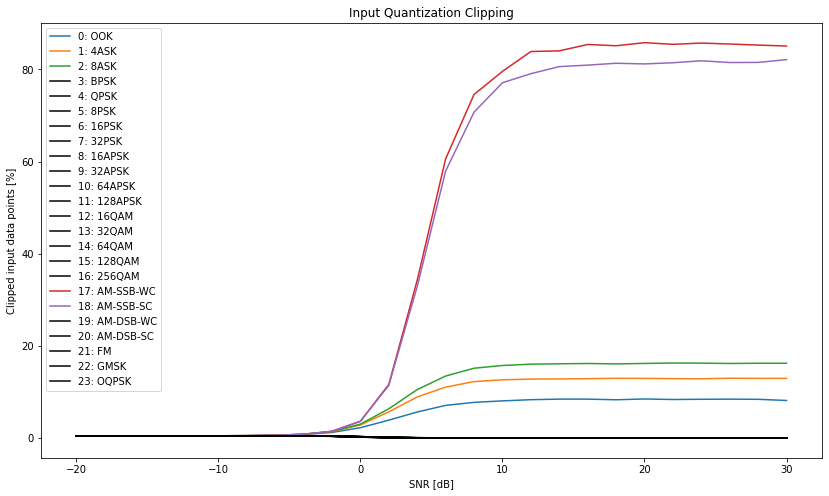

In [12]:
mods = range(0, 24)
coloring = [0, 17, 18, 1, 2]

quant_max = 2.0
quant_min = -quant_max
####
snr_idxs = range(0, 26)
clipped = np.zeros((24,len(snr_idxs)))
for mod in mods:
    for snr_idx in snr_idxs:
        idx = 26*4096*mod + 4096*snr_idx
        data = X[idx:idx+4096,:,:].flatten()
        clipped[mod][snr_idx] = np.count_nonzero((data < quant_min) | (data > quant_max))/len(data)

plt.figure(figsize=(14,8))
plt.title("Input Quantization Clipping")
plt.xlabel("SNR [dB]")
plt.ylabel("Clipped input data points [%]")
x = snr_classes[snr_idxs]
for mod in mods:
    if mod not in coloring:
        plt.plot(x, clipped[mod,:]*100, label=str(mod) + ": " + mod_classes[mod], color="black")
    else:
        plt.plot(x, clipped[mod,:]*100, label=str(mod) + ": " + mod_classes[mod])
plt.legend();


print("Mean clipping at -20 dB:")
print(np.mean(clipped[:,0]))
print("Mean clipping at +30 dB:")
print(np.mean(clipped[:,25]))
print("Mean clipping at +30 dB w/o SSB:")
print(np.mean(np.concatenate((clipped[0:17,25],clipped[19:24,25]))))

# Constellation diagrams

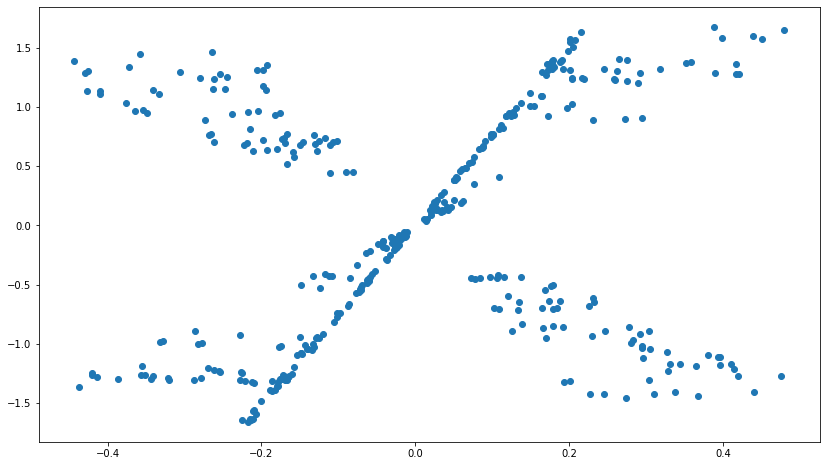

In [75]:
mod = 3
snr_idx = 25 # 0 to 25 = -20dB to +30dB
#####
idx = 26*4096*mod + 4096*snr_idx
no_samples = 3
data_I = X[idx:idx+no_samples,0::8,0]
data_Q = X[idx:idx+no_samples,0::8,1]

plt.figure(figsize=(14,8))
plt.scatter(data_I, data_Q)